# Temat Projektu: Klasyfikacja tekstu, detekcja fake-newsów
### Autor: Jerzy Muszyński

## Część 3: Generatywne Modele Językowe (Decoder-Only)

**Cel Notatnika:**
W ostatniej części projektu wkraczamy w świat wielkich modeli językowych (Large Language Models). W przeciwieństwie do modelu DistilBERT (który był klasyfikatorem), modele takie jak **Qwen** czy **Llama** są generatorami tekstu.
Ich zadaniem jest przewidywanie kolejnego słowa (Next Token Prediction). Aby zmusić je do klasyfikacji, musimy odpowiednio sformułować zadanie w języku naturalnym (Prompt Engineering).

**Metodologia:**
1.  **Architektura:** Decoder-Only (Autoregresyjna). Model czyta tekst tylko od lewej do prawej.
2.  **Badania Wstępne (Few-Shot):** Zanim zaczniemy trening, sprawdzimy zdolności modelu "prosto z pudełka" (In-Context Learning), podając mu kilka przykładów w prompcie. Porównamy wariant **Base** (surowy) oraz **Instruct** (przystosowany do czatu).
3.  **Trening (PEFT/QLoRA):** Ponieważ te modele są gigantyczne (miliardy parametrów), ich pełne dotrenowanie jest niemożliwe na standardowym sprzęcie. Zastosujemy technikę **QLoRA** (Quantized Low-Rank Adaptation):
    * **4-bit Quantization:** Skompresujemy wagi modelu 4-krotnie.
    * **LoRA:** Będziemy trenować tylko malutkie, doczepione macierze (adaptery), zostawiając główny model zamrożony.

In [ ]:
!nvidia-smi

Sat Jan 31 18:52:33 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## 1. Konfiguracja Środowiska dla LLM

Praca z LLM wymaga specjalistycznych bibliotek optymalizujących zużycie pamięci VRAM:
* **`bitsandbytes`**: Do kwantyzacji (kompresji) modelu do 4 bitów.
* **`peft`**: Do obsługi adapterów LoRA.
* **`trl` (Transformer Reinforcement Learning):** Zawiera `SFTTrainer`, który ułatwia trenowanie modeli generatywnych na instrukcjach.
* **`accelerate`**: Do efektywnego zarządzania obliczeniami na GPU.

Funkcja `cleanup()` jest tu kluczowa – jeden model LLM potrafi zająć całą pamięć karty graficznej, więc musimy agresywnie czyścić zasoby między eksperymentami.

In [ ]:
!pip -q install datasets scikit-learn umap-learn matplotlib torchmetrics evaluate peft bitsandbytes trl accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 45.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import gc
import pandas as pd
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from peft import LoraConfig
from trl import SFTTrainer
from datasets import load_dataset
from transformers import BitsAndBytesConfig
from peft import prepare_model_for_kbit_training, get_peft_model
import umap
import random

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.0+cu126


In [ ]:
is_cuda = torch.cuda.is_available()
print(f"GPU Availability: {is_cuda}")

if is_cuda:
  print(f"GPU type: {torch.cuda.get_device_name(0)}")
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

GPU Availability: True
GPU type: NVIDIA A100-SXM4-40GB


In [ ]:
def cleanup():
    if 'model' in globals():
        del globals()['model']
    if 'tokenizer' in globals():
        del globals()['tokenizer']
    if 'trainer' in globals():
        del globals()['trainer']

    gc.collect()
    torch.cuda.empty_cache()
    print("Memory cleaned.")

In [ ]:
def calculate_metrics_core(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    acc = accuracy_score(y_true, y_pred)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
def show_report_and_cm(y_true, y_pred, label_names = ["REAL", "FAKE"], title_prefix=""):
    print(f"\n=== Classification report ({title_prefix}) ===")
    print(classification_report(
        y_true, y_pred,
        target_names=label_names,
        digits=3
    ))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

    disp.plot(colorbar=False, cmap="Blues")
    plt.tight_layout()
    plt.title(f"Confusion matrix – {title_prefix}")
    plt.show()

In [ ]:
def plot_training_dynamics(trainer):
    history = trainer.state.log_history
    train_steps = [x['step'] for x in history if 'loss' in x]
    train_loss = [x['loss'] for x in history if 'loss' in x]

    eval_steps = [x['step'] for x in history if 'eval_loss' in x]
    eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

    plt.figure(figsize=(10, 5))
    plt.plot(train_steps, train_loss, label='Training Loss', color='tab:blue', alpha=0.7)
    if eval_loss:
        plt.plot(eval_steps, eval_loss, label='Validation Loss', color='tab:orange', linewidth=2)


    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Dynamics')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


def plot_embeddings_umap(embeddings, labels, title_prefix=""):
    X = np.array(embeddings)
    y = np.array(labels)

    reducer = umap.UMAP(n_components=2, random_state=42)
    X_2d = reducer.fit_transform(X)

    plt.figure(figsize=(7, 5))

    LABEL_NAMES = {0: "Fake", 1: "Real"}

    for lab in [0, 1]:
        idx = (y == lab)
        plt.scatter(
            X_2d[idx, 0],
            X_2d[idx, 1],
            s=10,
            alpha=0.7,
            label=LABEL_NAMES[lab]
        )

    plt.legend()
    plt.title(f"UMAP visualization {title_prefix}")
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
ds = load_dataset("ErfanMoosaviMonazzah/fake-news-detection-dataset-English")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/487 [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/78.4M [00:00<?, ?B/s]

validation.tsv:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8267 [00:00<?, ? examples/s]

In [ ]:
def add_input_text(data_point):
  title = data_point.get("title", "")
  text = data_point.get("text", "")
  data_point["input_text"] = (title.strip() + "\n " + text.strip()).strip()
  return data_point

In [ ]:
def prepare_encoder_data(dataset, model_name, max_length=512):
    print(f"Tokenizing data for {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize_batch(batch):
      return tokenizer(batch["input_text"], truncation=True, max_length=512)

    tokenized_ds = dataset.map(tokenize_batch, batched=True)

    return tokenized_ds, tokenizer

In [ ]:
ds = ds.map(add_input_text)
ds["train"][0]["input_text"]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8267 [00:00<?, ? examples/s]

"Ex-CIA head says Trump remarks on Russia interference 'disgraceful'\n Former CIA director John Brennan on Friday criticized as “disgraceful” President Donald Trump’s efforts to play down U.S. intelligence agencies’ assessment that Russia meddled in the 2016 U.S. election. Trump’s administration has been dogged by investigations into allegations of Russian interference in last year’s U.S. presidential election and possible ties with his campaign team. Speaking one day before his first meeting with Russian President Vladimir Putin in Hamburg earlier this month, Trump said he suspected Russian interference in the election but that no one knows for sure. “These types of comments are just disgraceful ... and the person who said them should be ashamed of himself,” said Brennan, CIA chief under former President Barack Obama, at the Aspen Security Forum. Special Counsel Robert Mueller and several U.S. congressional committees are investigating whether Russia interfered in the election and col

# Podejście 3 - Tylko dekoder

In [ ]:
MODELS_TO_COMPARE = {
    "Instruct": "Qwen/Qwen2.5-1.5B-Instruct",
    "Base": "Qwen/Qwen2.5-1.5B"
}

comparison_results = {}

ID2LABEL = {0: "Fake", 1: "Real"}
LABEL2ID = {"Fake": 0, "Real": 1}
SHOTS_TO_TEST = np.arange(1,6)

In [ ]:
SEED = random.seed(43)

In [ ]:
ds, tokenizer = prepare_encoder_data(ds, MODELS_TO_COMPARE["Base"])

Tokenizing data for Qwen/Qwen2.5-1.5B...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8267 [00:00<?, ? examples/s]

## 2. Inżynieria Promptów (Prompt Engineering)

To jest największa różnica względem BERTa. LLM nie przyjmuje "tabelki z danymi". Musimy z nim "porozmawiać".
Definiujemy dwie strategie formatowania danych:

1.  **Strategia Base (Completion):** Traktujemy zadanie jako autouzupełnianie tekstu.
    * *Wzór:* `News: [Treść] ... Label:` -> Model ma dopisać `Fake` lub `Real`.
2.  **Strategia Instruct (Chat):** Symulujemy rozmowę z asystentem AI.
    * *System Message:* "Jesteś ekspertem od wykrywania fake newsów..."
    * *User:* "Sklasyfikuj ten artykuł..."
    * *Assistant:* "Real"

Funkcje te będą używane zarówno do przygotowania danych treningowych, jak i do testowania modelu.

In [ ]:
def create_base_prompt(text, examples=[]):
    prompt = "Task: Classify the news article as 'Real' or 'Fake'.\n\n"
    for ex in examples:
        label = ID2LABEL[ex['label']]
        prompt += f"News: {ex['input_text'][:300]}...\nLabel: {label}\n\n"
    prompt += f"News: {text[:300]}...\nLabel:"
    return prompt

def create_instruct_prompt(text, tokenizer, examples=[]):
    messages = []
    instruction = "You are a fake news classifier. Respond with 'Real' or 'Fake'."

    for i, ex in enumerate(examples):
        content = f"News: {ex['input_text'][:300]}"
        if i == 0: content = f"{instruction}\n\n{content}"

        messages.append({"role": "user", "content": content})
        messages.append({"role": "assistant", "content": ID2LABEL[ex['label']]})

    target_content = f"News: {text[:300]}"
    if len(examples) == 0: target_content = f"{instruction}\n\n{target_content}"
    messages.append({"role": "user", "content": target_content})

    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

def run_inference(model, tokenizer, dataset, prompt_type="Base", n_samples=100, shots=3):
    subset = dataset.shuffle(seed=42).select(range(n_samples))
    few_shots = dataset.shuffle(seed=42).select(range(shots))

    preds, trues = [], []
    print(f"Running inference ({prompt_type} strategy)...")

    for sample in tqdm(subset):
        if prompt_type == "Base":
            prompt = create_base_prompt(sample['input_text'], few_shots)
        else:
            prompt = create_instruct_prompt(sample['input_text'], tokenizer, few_shots)

        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=2,
                pad_token_id=tokenizer.eos_token_id,
                do_sample=False
            )

        if prompt_type == "Instruct":
            new_tokens = outputs[0][inputs.input_ids.shape[1]:]
            ans = tokenizer.decode(new_tokens, skip_special_tokens=True)
        else:
            full = tokenizer.decode(outputs[0], skip_special_tokens=True)
            ans = full[len(prompt):]

        ans = ans.strip().lower()

        p = -1
        if "real" in ans: p = 1
        elif "fake" in ans: p = 0

        if p != -1:
            preds.append(p)
            trues.append(sample['label'])

    return trues, preds

## 3. Eksperyment Wstępny: Few-Shot Learning

Zanim poświęcimy czas i zasoby na trening (Fine-Tuning), chcemy sprawdzić, który wariant modelu (Base czy Instruct) lepiej "czuje" nasze zadanie.

**Metoda Few-Shot (Kilka strzałów):**
Zamiast uczyć modelu wag, podajemy mu w prompcie kilka rozwiązanych przykładów (np. 3 artykuły z etykietami) i prosimy o rozwiązanie czwartego. To wykorzystuje mechanizm atencji do "nauczenia się" zadania w locie (In-Context Learning).

**Cel eksperymentu:**
Przetestujemy liczbę przykładów (0-shot, 3-shot, 5-shot) dla obu wariantów modelu **Qwen-2.5-1.5B**. Zwycięska konfiguracja zostanie wybrana do dalszego etapu (Fine-Tuning).

In [ ]:
def run_few_shot_experiments(models_dict, dataset, shots_list=[0, 3, 5], n_samples=150):
    all_results = []

    for variant, model_name in models_dict.items():
        print(f"\n{'#'*60}")
        print(f"EVALUATING MODEL: {variant} ({model_name})")
        print(f"{'#'*60}")

        cleanup()

        print(f"Loading {model_name}...")
        try:
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token
            tokenizer.padding_side = "right"

            model = AutoModelForCausalLM.from_pretrained(
                model_name,
                torch_dtype=torch.bfloat16,
                device_map="auto"
            )
            model.config.use_cache = True
        except Exception as e:
            print(f"Error loading model {model_name}: {e}")
            continue

        for shots in shots_list:
            print(f"\n--- Testing {shots}-shot prompting ---")

            y_true, y_pred = run_inference(
                model, tokenizer, dataset,
                prompt_type=variant,
                n_samples=n_samples,
                shots=shots
            )

            metrics = calculate_metrics_core(y_true, y_pred)
            print(f"   -> Accuracy: {metrics['accuracy']:.3f}")

            result_entry = {
                "Model_Variant": variant,
                "Model_Name": model_name,
                "Shots": shots,
                **metrics
            }
            all_results.append(result_entry)

    cleanup()

    return pd.DataFrame(all_results)

### Wyniki Badań Few-Shot

Poniższa tabela i wykres pokazują, jak liczba podanych przykładów wpływa na jakość predykcji.
* Często modele **Instruct** radzą sobie lepiej w trybie 0-shot (bez przykładów), bo są nauczone podążania za instrukcjami.
* Modele **Base** często zyskują więcej przy dodawaniu przykładów (3-shot, 5-shot), bo "łapią wzorzec" formatowania tekstu.

Na podstawie parametru `accuracy` wybieramy **Zwycięzcę (Winner)**, który zostanie poddany treningowi QLoRA.

In [ ]:
def plot_few_shot_results(df_results, shots_list):
    if df_results.empty:
        print("No results to plot.")
        return

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    metrics_to_plot = ['accuracy', 'f1', 'precision', 'recall']

    variants = df_results['Model_Variant'].unique()
    colors = {"Base": "tab:blue", "Instruct": "tab:orange"}

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]

        for variant in variants:
            subset = df_results[df_results['Model_Variant'] == variant]
            subset = subset.sort_values(by='Shots')

            ax.plot(
                subset['Shots'],
                subset[metric],
                marker='o',
                linewidth=2,
                label=variant,
                color=colors.get(variant, None)
            )

        ax.set_title(metric.capitalize())
        ax.set_xlabel("Number of Shots")
        ax.set_ylabel("Score")
        ax.set_xticks(shots_list)
        ax.grid(True, linestyle='--', alpha=0.5)
        if i == 0: ax.legend()

    plt.suptitle("Impact of Few-Shot Prompting on Model Performance", fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
df_results = run_few_shot_experiments(
    MODELS_TO_COMPARE,
    ds["train"],
    shots_list=SHOTS_TO_TEST,
    n_samples=300
)


############################################################
EVALUATING MODEL: Instruct (Qwen/Qwen2.5-1.5B-Instruct)
############################################################
Memory cleaned.
Loading Qwen/Qwen2.5-1.5B-Instruct...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]


--- Testing 1-shot prompting ---
Running inference (Instruct strategy)...


100%|██████████| 150/150 [00:12<00:00, 12.44it/s]


   -> Accuracy: 0.713

--- Testing 2-shot prompting ---
Running inference (Instruct strategy)...


100%|██████████| 150/150 [00:10<00:00, 13.85it/s]


   -> Accuracy: 0.827

--- Testing 3-shot prompting ---
Running inference (Instruct strategy)...


100%|██████████| 150/150 [00:11<00:00, 13.62it/s]


   -> Accuracy: 0.780

--- Testing 4-shot prompting ---
Running inference (Instruct strategy)...


100%|██████████| 150/150 [00:10<00:00, 13.72it/s]


   -> Accuracy: 0.887

--- Testing 5-shot prompting ---
Running inference (Instruct strategy)...


100%|██████████| 150/150 [00:11<00:00, 13.38it/s]


   -> Accuracy: 0.860

############################################################
EVALUATING MODEL: Base (Qwen/Qwen2.5-1.5B)
############################################################
Memory cleaned.
Loading Qwen/Qwen2.5-1.5B...


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]


--- Testing 1-shot prompting ---
Running inference (Base strategy)...


100%|██████████| 150/150 [00:10<00:00, 13.71it/s]


   -> Accuracy: 0.813

--- Testing 2-shot prompting ---
Running inference (Base strategy)...


100%|██████████| 150/150 [00:10<00:00, 13.91it/s]


   -> Accuracy: 0.680

--- Testing 3-shot prompting ---
Running inference (Base strategy)...


100%|██████████| 150/150 [00:10<00:00, 13.82it/s]


   -> Accuracy: 0.480

--- Testing 4-shot prompting ---
Running inference (Base strategy)...


100%|██████████| 150/150 [00:10<00:00, 13.71it/s]


   -> Accuracy: 0.680

--- Testing 5-shot prompting ---
Running inference (Base strategy)...


100%|██████████| 150/150 [00:11<00:00, 13.51it/s]


   -> Accuracy: 0.833
Memory cleaned.


In [ ]:
print("\n" + "="*60)
print("FEW-SHOT PROMPTING EXPERIMENT RESULTS TABLE")
print("="*60)

print(df_results[['Model_Variant', 'Shots', 'accuracy', 'f1', 'precision', 'recall']]
      .sort_values(by=['accuracy'], ascending=False)
      .to_string(index=False))

best_row = df_results.loc[df_results['accuracy'].idxmax()]
best_variant = best_row['Model_Variant']
best_model_name = best_row['Model_Name']
best_acc = best_row['accuracy']

print(f"\nWINNER: {best_variant} ({best_model_name}) with {best_row['Shots']}-shot (Acc: {best_acc:.3f})")
print("This model/variant will be used for LoRA Fine-Tuning.")


FEW-SHOT PROMPTING EXPERIMENT RESULTS TABLE
Model_Variant  Shots  accuracy       f1  precision   recall
     Instruct      4  0.886667 0.872180   0.773333 1.000000
     Instruct      5  0.860000 0.842105   0.746667 0.965517
         Base      5  0.833333 0.736842   0.945946 0.603448
     Instruct      2  0.826667 0.808824   0.705128 0.948276
         Base      1  0.813333 0.708333   0.894737 0.586207
     Instruct      3  0.780000 0.778523   0.637363 1.000000
     Instruct      1  0.713333 0.426667   0.941176 0.275862
         Base      2  0.680000 0.703704   0.548077 0.982759
         Base      4  0.680000 0.294118   1.000000 0.172414
         Base      3  0.480000 0.597938   0.426471 1.000000

WINNER: Instruct (Qwen/Qwen2.5-1.5B-Instruct) with 4-shot (Acc: 0.887)
This model/variant will be used for LoRA Fine-Tuning.


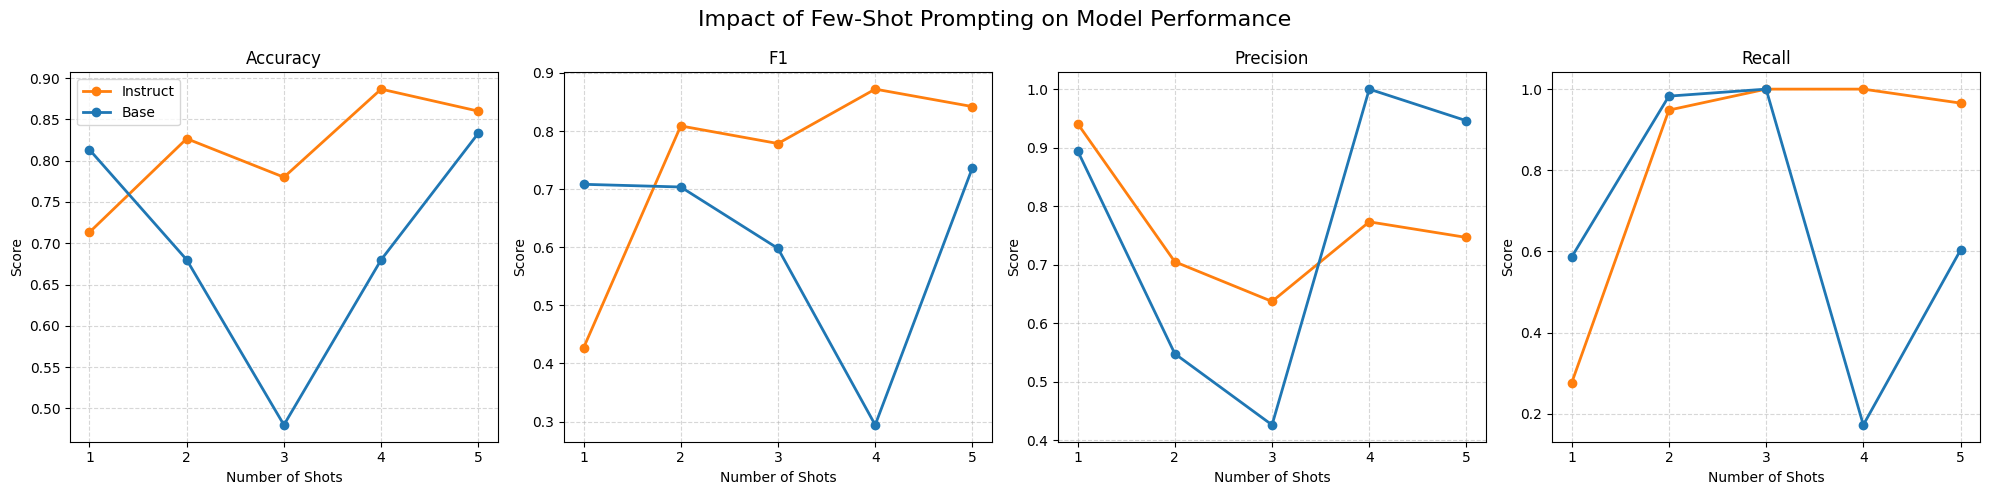

In [ ]:
plot_few_shot_results(df_results, SHOTS_TO_TEST)

In [ ]:
def get_formatting_function(variant, tokenizer, max_seq_length=512):
    def format_base(sample):
        text = sample['input_text']
        label = ID2LABEL[sample['label']]
        return f"Task: Classify the news article as 'Real' or 'Fake'.\n\nNews: {text[:max_seq_length]}\nLabel: {label}"

    def format_instruct(sample):
        text = sample['input_text']
        label = ID2LABEL[sample['label']]
        messages = [
            {"role": "user", "content": f"Classify this news article:\n{text[:max_seq_length]}"},
            {"role": "assistant", "content": label}
        ]
        return tokenizer.apply_chat_template(messages, tokenize=False)

    return format_base if variant == "Base" else format_instruct

def load_model_for_qlora(model_name):
    print(f"Loading {model_name} in 4-bit (QLoRA)...")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )

    model.config.use_cache = False
    model.config.pretraining_tp = 1
    model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})

    model = prepare_model_for_kbit_training(model)

    return model, tokenizer

## 4. Efektywny Trening: QLoRA (Quantized Low-Rank Adaptation)

To serce tego notatnika. Zamiast trenować wszystkie 1.5 miliarda parametrów (co wymagałoby potężnego klastra GPU), stosujemy sprytne podejście:

1.  **Zamrażamy model (Freeze):** Główny "mózg" modelu jest ładowany w 4-bitach (bardzo niska precyzja, duża kompresja) i nie jest modyfikowany.
2.  **Adaptery LoRA:** Doklejamy do modelu malutkie macierze wag (stanowiące mniej niż 1% całości).
3.  **Trening:** Uczymy TYLKO te małe macierze.

Dzięki temu model zachowuje swoją ogólną wiedzę o języku (z 4-bitowej bazy), a jednocześnie uczy się specyfiki naszego zbioru Fake News (dzięki adapterom). Używamy do tego biblioteki `SFTTrainer` (Supervised Fine-Tuning Trainer).

In [ ]:
def run_training_qlora(model, tokenizer, train_data, val_data, output_dir, learning_rate=2e-4):
    """
    Configures and executes the SFTTrainer with LoRA.
    """
    peft_config = LoraConfig(
        r=8,
        lora_alpha=16,
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=[
            "q_proj", "v_proj", "k_proj", "o_proj",
            "gate_proj", "up_proj", "down_proj"
        ]
    )

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=learning_rate,
        report_to="none",
        logging_steps=50,
        eval_strategy="steps",
        load_best_model_at_end=True,
    )

    trainer = SFTTrainer(
        model=model,
        train_dataset=train_data,
        eval_dataset=val_data,
        peft_config=peft_config,
        args=training_args,
    )

    print("Starting Training...")
    trainer.train()
    print(f"Training finished. Model adapted in {output_dir}")

    return trainer

In [ ]:
def fine_tune_winner(model_name, variant, dataset, n_train_samples=2000, n_val_samples=300):
    """
    Orchestrator function:
    1. Prepares data
    2. Loads model
    3. Runs training
    """
    cleanup()

    model, tokenizer = load_model_for_qlora(model_name)

    print(f"Preparing training data using '{variant}' format strategy...")
    formatter = get_formatting_function(variant, tokenizer)

    train_dataset = dataset['train'].shuffle(seed=SEED).select(range(n_train_samples))
    train_dataset = train_dataset.map(lambda x: {"formatted_text": formatter(x)})

    val_dataset = dataset['validation'].shuffle(seed=SEED).select(range(n_val_samples))
    val_dataset = val_dataset.map(lambda x: {"formatted_text": formatter(x)})

    output_dir = f"./{variant}_qlora_adapter"
    trainer = run_training_qlora(model, tokenizer, train_dataset, val_dataset, output_dir)

    return trainer, tokenizer

In [ ]:
if best_model_name is None:
    print("WARNING: No best model selected. Please run the previous cell first.")
else:
    print(f"Launching Fine-Tuning for Winner: {best_model_name} ({best_variant})")

    trainer, tokenizer = fine_tune_winner(
        best_model_name,
        best_variant,
        ds,
        n_train_samples=3000
    )

Launching Fine-Tuning for Winner: Qwen/Qwen2.5-1.5B-Instruct (Instruct)
Memory cleaned.
Loading Qwen/Qwen2.5-1.5B-Instruct in 4-bit (QLoRA)...
Preparing training data using 'Instruct' format strategy...


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:2111: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(


Truncating train dataset:   0%|          | 0/3000 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Starting Training...


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
50,2.679200,2.619128
100,2.583500,2.591382
150,2.585900,2.576607
200,2.515500,2.569568
250,2.473200,2.571249
300,2.459500,2.567063
350,2.475200,2.561278
400,2.424800,2.569889
450,2.370900,2.570711
500,2.389500,2.569314


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Training finished. Model adapted in ./Instruct_qlora_adapter


In [ ]:
def predict_llm_few_shot(model, tokenizer, dataset, variant, n_samples=300, shots=3):
    model.eval()

    subset = dataset.shuffle(seed=42).select(range(n_samples))

    few_shot_examples = ds['train'].shuffle(seed=42).select(range(shots))

    y_true, y_pred = [], []


    for i, sample in tqdm(enumerate(subset), total=n_samples):
        text = sample['input_text']

        if variant == "Base":
            prompt = create_base_prompt(text, few_shot_examples)
        else:
            prompt = create_instruct_prompt(text, tokenizer, few_shot_examples)

        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=5,
                pad_token_id=tokenizer.eos_token_id,
                do_sample=False
            )

        full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        if variant == "Instruct":
             if "assistant" in full_text:
                 ans = full_text.split("assistant")[-1]
             else:
                 ans = full_text[len(prompt):]
        else:
             ans = full_text[len(prompt):]

        ans = ans.strip().lower()

        pred = -1
        if "real" in ans: pred = 1
        elif "fake" in ans: pred = 0

        if pred != -1:
            y_true.append(sample['label'])
            y_pred.append(pred)

    return np.array(y_true), np.array(y_pred)

In [ ]:
def extract_embeddings(model, tokenizer, dataset, variant, n_samples=300, max_seq_length=512):
    model.eval()
    subset = dataset.shuffle(seed=42).select(range(n_samples))
    embeddings, labels = [], []


    for sample in tqdm(subset):
        text = sample['input_text']

        if variant == "Base":
            prompt = f"Task: Classify...\n\nNews: {text[:max_seq_length]}\nLabel:"
        else:
            messages = [{"role": "user", "content": f"Classify this news:\n{text[:max_seq_length]}"}]
            prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        emb = outputs.hidden_states[-1][:, -1, :].cpu().numpy()[0]

        embeddings.append(emb)
        labels.append(sample['label'])

    return embeddings, labels

In [ ]:
def extract_llm_embeddings_stable(model, tokenizer, dataset, variant, n_samples=1000, batch_size=8, max_seq_length=512):
    n_samples = min(n_samples, len(dataset))
    subset = dataset.shuffle(seed=42).select(range(n_samples))

    texts = subset["input_text"]
    labels = subset["label"]

    model.eval()
    embeddings = []

    print(f"Extracting embeddings for {n_samples} samples ({variant})...")

    for i in tqdm(range(0, n_samples, batch_size)):
        batch_raw_texts = texts[i : i + batch_size]
        batch_prompts = []

        for text in batch_raw_texts:
            if variant == "Base":
                prompt = f"Task: Classify the news article as 'Real' or 'Fake'.\n\nNews: {text[:max_seq_length]}\nLabel:"
                batch_prompts.append(prompt)
            else:
                messages = [
                    {"role": "user", "content": f"Classify this news article:\n{text[:max_seq_length]}"}
                ]
                prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
                batch_prompts.append(prompt)

        inputs = tokenizer(
            batch_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_seq_length + 64
        ).to(model.device)

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        last_token_emb = outputs.hidden_states[-1][:, -1, :].cpu().numpy()
        embeddings.append(last_token_emb)

    X = np.concatenate(embeddings, axis=0)
    y = np.array(labels)

    return X, y


In [ ]:
def visualize_llm_embeddings(trainer, dataset, variant, title_prefix, n_samples=1000):
    X, y = extract_llm_embeddings_stable(
        trainer.model,
        trainer.tokenizer,
        dataset,
        variant=variant,
        n_samples=n_samples,
        batch_size=8
    )

    print("Computing UMAP projection...")
    reducer = umap.UMAP(n_components=2, random_state=42)
    X_2d = reducer.fit_transform(X)

    plt.figure(figsize=(7, 5))
    LABEL_NAMES = {0: "Fake", 1: "Real"}

    for lab in [0, 1]:
        idx = (y == lab)
        plt.scatter(
            X_2d[idx, 0],
            X_2d[idx, 1],
            s=10,
            alpha=0.7,
            label=LABEL_NAMES[lab]
        )

    plt.legend()
    plt.title(f"UMAP visualization (QLoRA) - {title_prefix}")
    plt.show()

In [ ]:
def evaluate_llm_pipeline(trainer, tokenizer, dataset, best_variant):

    print("\n--- FULL EVALUATION ---")

    plot_training_dynamics(trainer)

    for split_name in ["train", "test", "validation"]:
        print(f"\nEvaluating on {split_name} set...")


        y_true, y_pred = predict_llm_few_shot(
            trainer.model,
            tokenizer,
            dataset[split_name],
            best_variant,
            n_samples=300,
            shots=5
        )

        if len(y_pred) > 0:
            show_report_and_cm(y_true, y_pred, title_prefix=f"{split_name.capitalize()} Set")
            visualize_llm_embeddings(trainer, dataset[split_name], best_variant, title_prefix=f"{split_name.capitalize()} Set")
        else:
            print(f"Warning: No valid predictions generated for {split_name} set.")

## 5. Ewaluacja Modelu po Dotrenowaniu

Po zakończeniu treningu QLoRA, nasz model posiada teraz "wiedzę wbudowaną" o zadaniu.
Sprawdzamy jego skuteczność na zbiorze testowym.

**Ważna uwaga techniczna:**
Ponieważ model jest generatorem, może wygenerować cokolwiek (np. "This is clearly fake news" zamiast samego słowa "Fake").
Dlatego stosujemy funkcję parsującą, która szuka słów kluczowych ("real", "fake") w wygenerowanej odpowiedzi. Dodatkowo wspieramy model techniką 5-shot prompting podczas testu, aby wymusić na nim trzymanie się krótkiego formatu odpowiedzi.


--- FULL EVALUATION ---


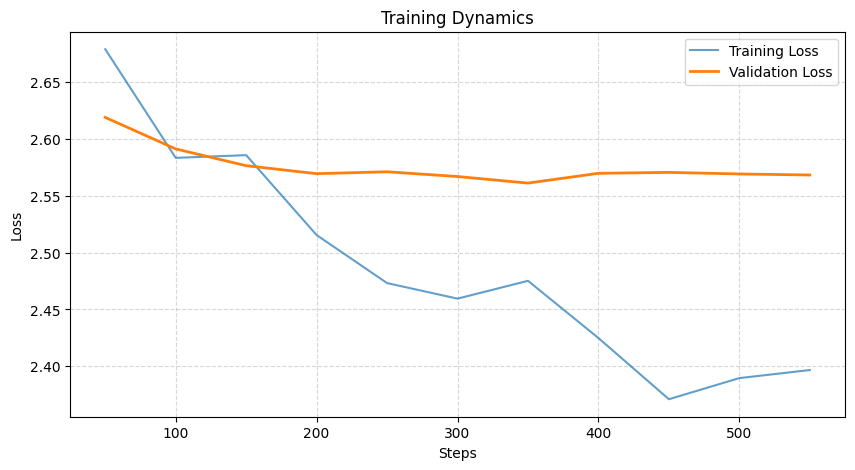


Evaluating on train set...


100%|██████████| 300/300 [01:29<00:00,  3.35it/s]


=== Classification report (Train Set) ===
              precision    recall  f1-score   support

        REAL      0.879     0.868     0.873       159
        FAKE      0.853     0.865     0.859       141

    accuracy                          0.867       300
   macro avg      0.866     0.867     0.866       300
weighted avg      0.867     0.867     0.867       300



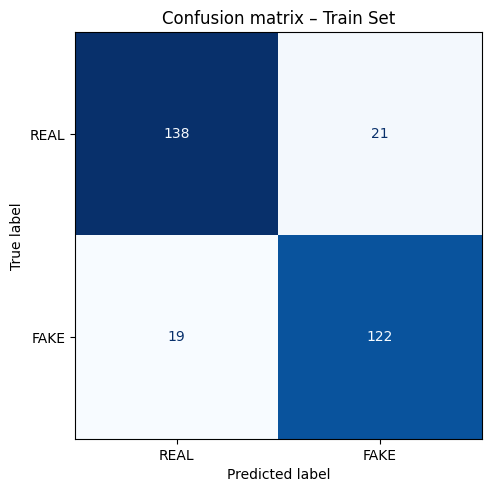

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Extracting embeddings for 1000 samples (Instruct)...


100%|██████████| 125/125 [00:24<00:00,  5.08it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP projection...


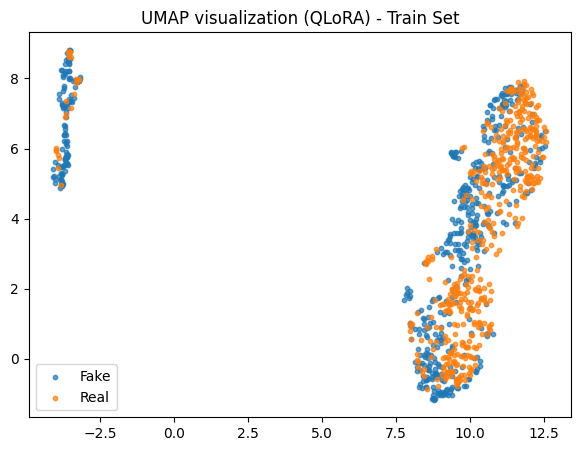


Evaluating on test set...


100%|██████████| 300/300 [01:28<00:00,  3.39it/s]


=== Classification report (Test Set) ===
              precision    recall  f1-score   support

        REAL      0.910     0.841     0.874       157
        FAKE      0.839     0.909     0.872       143

    accuracy                          0.873       300
   macro avg      0.875     0.875     0.873       300
weighted avg      0.876     0.873     0.873       300



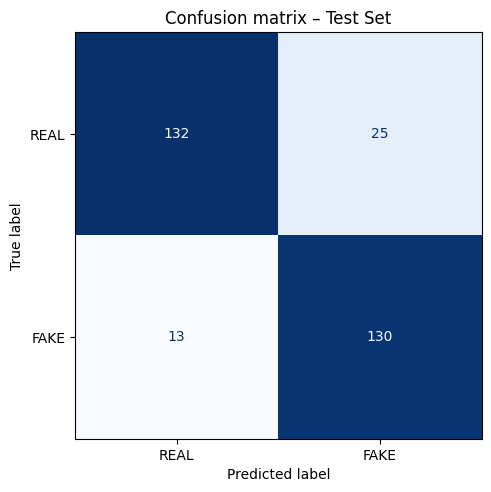

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Extracting embeddings for 1000 samples (Instruct)...


100%|██████████| 125/125 [00:24<00:00,  5.11it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP projection...


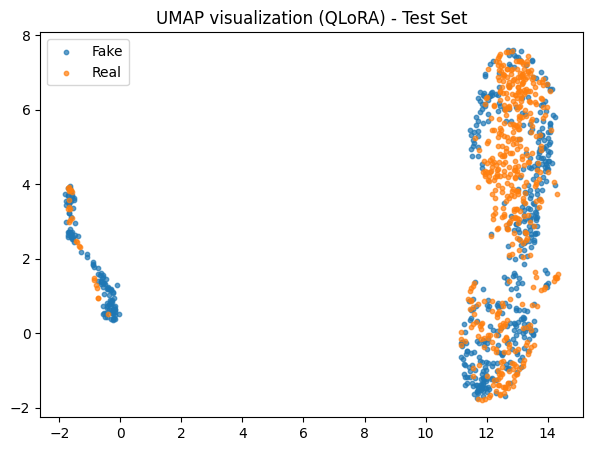


Evaluating on validation set...


100%|██████████| 300/300 [01:28<00:00,  3.37it/s]


=== Classification report (Validation Set) ===
              precision    recall  f1-score   support

        REAL      0.874     0.841     0.857       157
        FAKE      0.832     0.867     0.849       143

    accuracy                          0.853       300
   macro avg      0.853     0.854     0.853       300
weighted avg      0.854     0.853     0.853       300



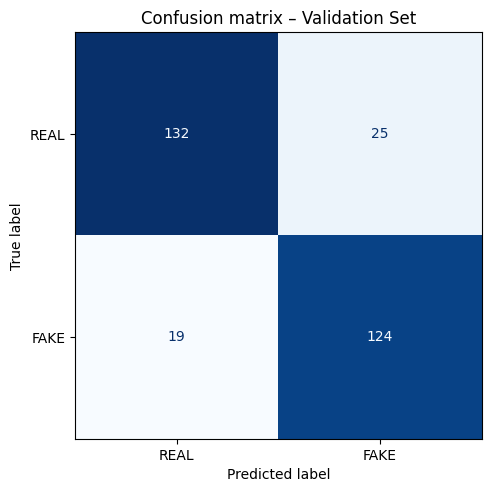

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Extracting embeddings for 1000 samples (Instruct)...


100%|██████████| 125/125 [00:24<00:00,  5.12it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP projection...


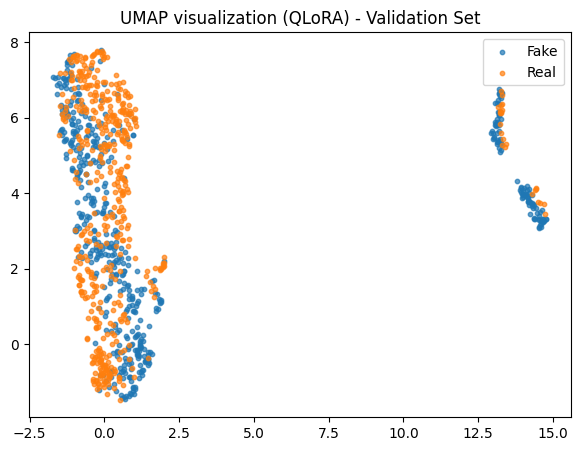

In [ ]:
evaluate_llm_pipeline(trainer, tokenizer, ds, best_variant)

# Podsumowanie Projektu

W ramach tego trzyczęściowego eksperymentu przeszliśmy drogę od klasycznych metod NLP do najnowocześniejszych modeli generatywnych.

**Porównanie podejść:**
1.  **TF-IDF (Baseline):** Szybki, tani, ale ograniczony do słów kluczowych.
2.  **Encoder (DistilBERT):** Świetny w rozumieniu kontekstu, bardzo skuteczny w klasyfikacji, łatwy do trenowania. Często jest to "złoty środek" w zastosowaniach produkcyjnych.
3.  **Decoder (LLM + QLoRA):** Potężny model o ogólnej wiedzy.
    * *Zalety:* Możliwość pracy bez treningu (Few-Shot), rozumienie bardzo złożonych niuansów.
    * *Wady:* Ogromne wymagania sprzętowe, trudniejsza ewaluacja (generuje tekst, a nie klasę), wolniejszy czas działania.

**Wniosek końcowy:**
W specyficznym zadaniu binarnej klasyfikacji fake newsów, mniejszy i w pełni dotrenowany model Encoder (BERT) często dorównuje lub przewyższa wielkie modele LLM adaptowane metodą LoRA, będąc przy tym znacznie bardziej ekonomicznym rozwiązaniem.